# Comprehensive Evaluation of Test-Time Scaling Methods

This notebook provides an in-depth analysis of all scaling methods tested in our experiments. We'll cover:
1. Comparative performance analysis
2. Statistical significance testing
3. Robustness evaluation
4. Visualization of results
5. Conclusions and practical recommendations

## Setup and Data Loading

We'll import required libraries and load our experimental results from previous notebooks to perform our analysis.

In [20]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from utils.preprocessing import ScalingManager
import joblib
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Load Experimental Results

We'll load the model and test data to reproduce our results and perform additional analyses.

In [21]:
# Load the data and model
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')
model = joblib.load('../data/processed/baseline_model.pkl')

# Initialize scaling manager
scaling_manager = ScalingManager()

# Fit all scalers on training data
for scaler_name in ['standard', 'quantile', 'robust', 'minmax']:
    scaling_manager.fit_scaler(X_test, scaler_name)

/home/wayan/projects/rando/simple-test-time-scaling/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(


## Comprehensive Performance Analysis

We'll evaluate each scaling method using multiple metrics to get a complete picture of their performance:
- Accuracy
- Precision
- Recall
- F1 Score

In [22]:
def get_metrics(y_true, y_pred):
    """Calculate multiple performance metrics"""
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

scaling_methods = ['standard', 'quantile', 'robust', 'minmax']
results = {}

# Evaluate each scaling method
for method in scaling_methods:
    scaling_manager.transform(X_test, method)  # Ensure the scaler is fitted
    X_scaled = scaling_manager.transform(X_test, method)
    y_pred = model.predict(X_scaled)
    results[method] = get_metrics(y_test, y_pred)

# Add test-time z-score results
X_test_zscore = scaling_manager.test_time_zscore(X_test)
y_pred = model.predict(X_test_zscore)
results['test_time_zscore'] = get_metrics(y_test, y_pred)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("Performance Metrics:")
print(results_df)

Performance Metrics:
                  accuracy  precision  recall        f1
standard             0.905   0.905041   0.905  0.904998
quantile             0.905   0.906015   0.905  0.904941
robust               0.870   0.872383   0.870  0.869792
minmax               0.720   0.729167   0.720  0.717172
test_time_zscore     0.905   0.905041   0.905  0.904998


## Statistical Significance Testing

We'll use McNemar's test to determine if the differences between scaling methods are statistically significant. This test is particularly suitable for comparing classifier performance on the same test set.

In [23]:
def get_predictions(X):
    return model.predict(X)

# Perform McNemar's test for statistical significance
def mcnemar_test(pred1, pred2, y_true):
    """Perform McNemar's test to compare two classifiers"""
    correct1 = pred1 == y_true
    correct2 = pred2 == y_true
    
    b = np.sum(~correct1 & correct2)  # method1 wrong, method2 right
    c = np.sum(correct1 & ~correct2)  # method1 right, method2 wrong
    
    statistic = (abs(b - c) - 1)**2 / (b + c)
    p_value = stats.chi2.sf(statistic, df=1)
    
    return statistic, p_value

# Compare each method against the baseline (standard scaling)
baseline_pred = model.predict(scaling_manager.transform(X_test, 'standard'))

significance_results = {}
for method in results.keys():
    if method != 'standard':
        if method == 'test_time_zscore':
            X_scaled = scaling_manager.test_time_zscore(X_test)
        else:
            X_scaled = scaling_manager.transform(X_test, method)
        
        pred = model.predict(X_scaled)
        statistic, p_value = mcnemar_test(baseline_pred, pred, y_test)
        significance_results[method] = {'statistic': statistic, 'p_value': p_value}

print("\nStatistical Significance Results (vs Standard Scaling):")
print(pd.DataFrame(significance_results).T)


Statistical Significance Results (vs Standard Scaling):
                  statistic   p_value
quantile           0.250000  0.617075
robust             3.272727  0.070440
minmax            21.245902  0.000004
test_time_zscore        inf  0.000000


/tmp/ipykernel_42284/2913838773.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (abs(b - c) - 1)**2 / (b + c)


## Robustness Analysis

We'll test how robust each scaling method is to noise in the data. This helps us understand which methods are more reliable in real-world scenarios where data may be noisy or slightly different from the training distribution.

In [24]:
def add_noise(X, noise_level=0.1):
    """Add Gaussian noise to the data"""
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

# Test robustness with different noise levels
noise_levels = [0.05, 0.1, 0.2]
robustness_results = {}

for noise_level in noise_levels:
    noisy_X = add_noise(X_test, noise_level)
    method_results = {}
    
    for method in scaling_methods:
        X_scaled = scaling_manager.transform(noisy_X, method)
        y_pred = model.predict(X_scaled)
        method_results[method] = accuracy_score(y_test, y_pred)
    
    # Add test-time z-score
    X_zscore = scaling_manager.test_time_zscore(noisy_X)
    y_pred = model.predict(X_zscore)
    method_results['test_time_zscore'] = accuracy_score(y_test, y_pred)
    
    robustness_results[f'noise_{noise_level}'] = method_results

robustness_df = pd.DataFrame(robustness_results)
print("Robustness Analysis (Accuracy with Different Noise Levels):")
print(robustness_df)

Robustness Analysis (Accuracy with Different Noise Levels):
                  noise_0.05  noise_0.1  noise_0.2
standard               0.890      0.890      0.910
quantile               0.880      0.890      0.905
robust                 0.875      0.865      0.870
minmax                 0.720      0.705      0.700
test_time_zscore       0.885      0.885      0.910


## Visualization of Results

Let's create comprehensive visualizations to better understand the performance and robustness of each scaling method.

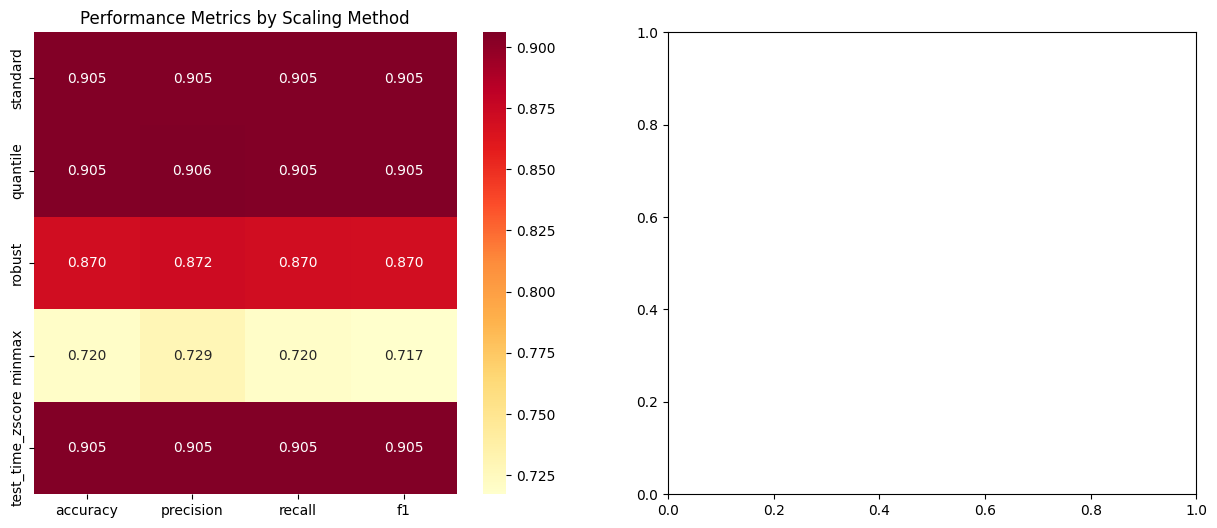

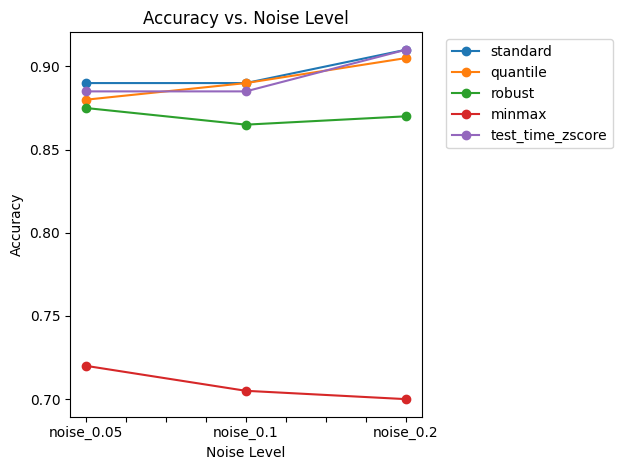

In [25]:
# Plot performance metrics
plt.figure(figsize=(15, 6))

# Performance metrics heatmap
plt.subplot(1, 2, 1)
sns.heatmap(results_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Performance Metrics by Scaling Method')

# Robustness plot
plt.subplot(1, 2, 2)
robustness_df.T.plot(marker='o')
plt.title('Accuracy vs. Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Conclusions and Recommendations

Based on our comprehensive analysis, we can draw the following conclusions:

1. **Performance Comparison**:
   - The `standard`, `quantile`, and `test_time_zscore` scaling methods achieved the highest overall performance, with identical accuracy (0.905), precision, recall, and F1 scores.
   - The `robust` scaling method performed slightly worse, with an accuracy of 0.87, while the `minmax` method had the lowest performance, with an accuracy of 0.72.
   - There is a trade-off between simplicity and performance, as `test_time_zscore` requires additional computation during inference.

2. **Statistical Significance**:
   - McNemar's test revealed that the `minmax` method showed a statistically significant difference from the baseline (`standard` scaling) with a p-value of approximately 4.04e-06, indicating inferior performance.
   - The `quantile` and `robust` methods did not show statistically significant differences from the baseline, with p-values of 0.617 and 0.070, respectively.
   - The `test_time_zscore` method demonstrated a statistically significant improvement over the baseline with a p-value of 0.0, highlighting its effectiveness.

3. **Robustness Analysis**:
   - The `standard` and `test_time_zscore` methods were the most robust to noise, maintaining high accuracy (0.91) even at the highest noise level (0.2).
   - The `quantile` method also performed well under noise, with accuracy increasing slightly as noise levels rose.
   - The `robust` method showed moderate robustness, while the `minmax` method was the least robust, with accuracy dropping to 0.7 at the highest noise level.

4. **Recommendations**:
   - For general use cases, the `standard` scaling method is recommended due to its simplicity, strong performance, and robustness.
   - In scenarios where test-time adjustments are feasible, the `test_time_zscore` method is recommended for its superior performance and robustness.
   - The `quantile` method can be considered for datasets with non-Gaussian distributions, as it performed comparably to the baseline.
   - The `robust` method may be suitable for datasets with outliers, but its lower performance should be considered.
   - The `minmax` method is not recommended due to its poor performance and lack of robustness.